                                                                                   Group B
                                                                                   21/03/2018

# Final Course Assignment: Machine Learning with Spark
</p>
Final Course Assignment consists on solving a machine learning challenge making use of the
Spark machine learning tools and Spark technology learned during the course. 

#### Working Environment
You chose the provided IE cluster because ut would be a better representation of a real life scenario.


#### Expected Outputs
1. A Jupyter Notebook with the model implementation. Named as: Spark-Final-Assignment-Group-N-Challenge-M.ipynb where N ={1..8} and M = {1,2,3}
2. A presentation of the results ( 8 + 5 min for questions ) on last session 22nd Mar 2018.

#### Challenge 1 : Network Intrusion Detection
Network intrusion is a common security problem in large and medium size companies. Being
able to find ‘patterns’ in the network traffic allows to implement preemptive actions that save
money to companies.

### 1. Load Data

In [2]:
import os
my_home=os.environ['HOME']
dataset_path="/data/shared/spark/challenge_1/"
outputs_path=my_home

In [3]:
import os
print(os.environ['SPARK_HOME'])
print(os.environ['PYSPARK_PYTHON'])

/usr/share/spark
/usr/bin/python3.6


In [4]:
import findspark
findspark.init()
import pyspark

In [5]:
# Create a SparkSession and specify configuration
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("spark://data1p:7077") \
    .appName("group-b-final2") \
    .getOrCreate()

In [1]:
!ls -l /data/shared/spark/challenge_1/

total 1264160
-rwxr-xr-x 1 root root  74889749 Mar 19 18:28 10_percent.data
-rwxr-xr-x 1 root root  47251540 Mar 10 16:23 corrected
-rwxr-xr-x 1 root root 742579829 Mar 10 16:21 full.data
-rwxr-xr-x 1 root root      1307 Mar 10 16:20 names
-rwxr-xr-x 1 root root 429760105 Mar 10 16:22 testdata.unlabeled
-rwxr-xr-x 1 root root       272 Mar 10 16:23 training_attack_types


In [6]:
spark

In [20]:
# Reading .data files with all info and assigning correc colNames
train_set = spark.read \
    .option("inferSchema", "true") \
    .csv("file://"+dataset_path+"full.data")
    
test_set = spark.read \
    .option("inferSchema","true") \
    .csv("file://"+dataset_path+"testdata.unlabeled")

features=[ "duration","protocol_type","service", \
            "flag","src_bytes","dst_bytes", \
            "land","wrong_fragment","urgent", \
            "hot","num_failed_logins","logged_in", \
            "num_compromised","root_shell","su_attempted", \
            "num_root","num_file","num_shells","num_access_files", \
            "num_outbound_cmds","is_host_login","is_guest_login", \
            "count","srv_count","serror_rate","srv_serror_rate", \
            "rerror_rate","srv_rerror_rate","same_srv_rate", \
            "diff_srv_rate","srv_diff_host_rate","dst_host_count", \
            "dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate", \
            "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate", \
            "dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate", \
            "dst_host_srv_rerror_rate","label"]

rawnames=train_set.schema.names

# Create a small function
def updateColNames(df,oldnames,newnames):
    for i in range(len(newnames)):
        df=df.withColumnRenamed(oldnames[i], newnames[i])
    return df

train_set = updateColNames(train_set,rawnames,features)

train_set.printSchema()

root
 |-- duration: integer (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: integer (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: integer (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: integer (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: integer (nullable = true)
 |-- is_guest_login: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- srv

In [ ]:
train_set2 = spark.read \
    .option("inferSchema", "true") \
    .csv("file://"+dataset_path+"full.data")

In [10]:
str_list = [item[0] for item in train_set.dtypes if item[1].startswith('string')]
num_list = [item[0] for item in train_set.dtypes if item[1].startswith(('int','double'))]

### 2. Inspect Data

How many records and shape of the dataset.

In [85]:
train_set.toPandas().shape

(4898431, 43)

Describe the variables that COULD be more relevant to detect a network intrusion.

In [12]:
train_set.select(num_list).toPandas().describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,...,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06
mean,4.834243e+01,1.834621e+03,1.093623e+03,5.716116e-06,6.487792e-04,7.961733e-06,1.243766e-02,3.205108e-05,1.435290e-01,8.088304e-03,...,2.329811e+02,1.892142e+02,7.537132e-01,3.071111e-02,6.050520e-01,6.464107e-03,1.780911e-01,1.778859e-01,5.792780e-02,5.765941e-02
std,7.233298e+02,9.414311e+05,6.450123e+05,2.390833e-03,4.285434e-02,7.215084e-03,4.689782e-01,7.299408e-03,3.506116e-01,3.856481e+00,...,6.402094e+01,1.059128e+02,4.111860e-01,1.085432e-01,4.809877e-01,4.125978e-02,3.818382e-01,3.821774e-01,2.309428e-01,2.309777e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.550000e+02,4.900000e+01,4.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,5.200000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.550000e+02,2.550000e+02,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,1.032000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.550000e+02,2.550000e+02,1.000000e+00,4.000000e-02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,5.832900e+04,1.379964e+09,1.309937e+09,1.000000e+00,3.000000e+00,1.400000e+01,7.700000e+01,5.000000e+00,1.000000e+00,7.479000e+03,...,2.550000e+02,2.550000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


Information on the target variable: "connection_type".

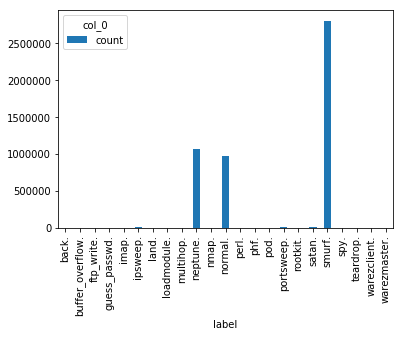

In [86]:
import pandas as pd
%matplotlib inline 
my_tab = pd.crosstab(index = train_set.toPandas()["label"], columns="count")
my_tab.plot.bar();

In [25]:
my_tab.sort_values(by='count', ascending=False)

col_0,count
label,
smurf.,2807886
neptune.,1072017
normal.,972781
satan.,15892
ipsweep.,12481
portsweep.,10413
nmap.,2316
back.,2203
warezclient.,1020


Inspect the distribution of connection time in "duration" by type of connection.

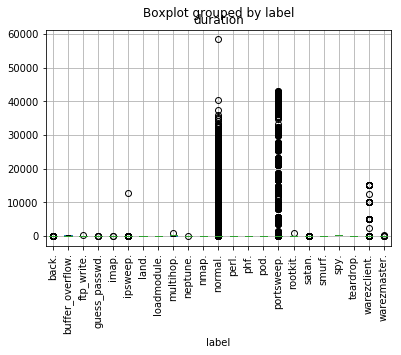

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = train_set.toPandas().boxplot(column="duration",
                             by= "label")
for tick in ax.get_xticklabels():
    tick.set_rotation(90);

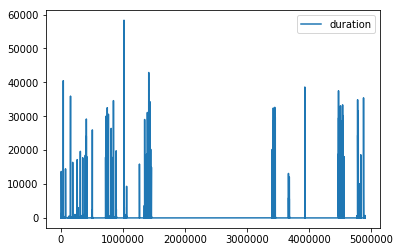

In [88]:
train_set.select("duration").toPandas().plot();

We can appreciate two clear clusters of duration in the dataset.

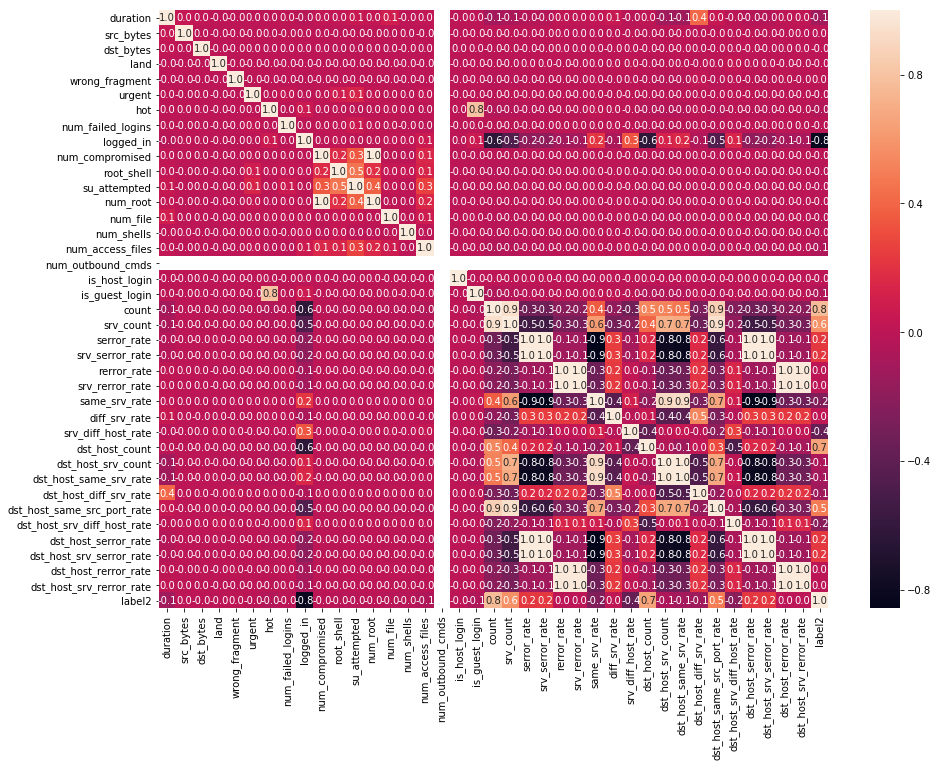

In [89]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 11)
sns.heatmap(train_set.toPandas().corr(),annot=True,fmt=".1f");

Levels of the string variables.

In [30]:
for col in str_list:
    print(col, train_set.select(col).distinct().count())

protocol_type 3
service 70
flag 11
label 23


### 3. Preprocess Data

In this phase we will binarize our dataset (either the connection is "good" - 0 or "bad" - 1).

In [21]:
# 
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
import pandas as pd
 
binarize = lambda x: 1 if x != 'normal.' else 0
 
udfValueToCategory = udf(binarize, IntegerType())
train_set = train_set.withColumn("label2", udfValueToCategory("label"))
pd.crosstab(index = train_set.toPandas()["label2"], columns="count")

col_0,count
label2,
0,972781
1,3925650


In [63]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ["protocol_type","service","flag"]

stages = [] # stages in our Pipeline.
for col in categoricalColumns:
  # Category Indexing with StringIndexer.
  indexer = StringIndexer(inputCol=col, outputCol=col+"_index")
  # Use OneHotEncoder to convert categorical variables into binary SparseVectors.
  encoder = OneHotEncoder(inputCol=col+"_index", outputCol=col+"_vector")
  # Add stages.  These are not run here, but will run all at once later on.
  stages += [indexer, encoder]

In [65]:
# Transform all numerical features into a vector using VectorAssembler.
numericCols = num_list
assemblerInputs = [ col + "_vector" for col in categoricalColumns ] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [66]:
print(assemblerInputs)

['protocol_type_vector', 'service_vector', 'flag_vector', 'duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


### 4. Create A Model

In [67]:
from pyspark.ml import Pipeline
# Create a Pipeline.
pipeline = Pipeline(stages=stages)

# Run the feature transformations.
transformer = pipeline.fit(train_set)
transformed_df = transformer.transform(train_set)

In [73]:
transformed_df.schema.names

['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'label',
 'label2',
 'protocol_type_index',
 'protocol_type_vector',
 'service_index',
 'service_vector',
 'flag_index',
 'flag_vector',
 'features',
 'features']

In [76]:
selection = ["features", "label"] 
dataset = transformed_df.select(selection)

In [77]:
dataset.show()

+--------------------+-------+
|            features|  label|
+--------------------+-------+
|(119,[1,4,71,82,8...|normal.|
|(119,[1,4,71,82,8...|normal.|
|(119,[1,4,71,82,8...|normal.|
|(119,[1,4,71,82,8...|normal.|
|(119,[1,4,71,82,8...|normal.|
|(119,[1,4,71,82,8...|normal.|
|(119,[1,4,71,82,8...|normal.|
|(119,[1,4,71,82,8...|normal.|
|(119,[1,4,71,82,8...|normal.|
|(119,[1,4,71,82,8...|normal.|
|(119,[1,4,71,82,8...|normal.|
|(119,[1,4,71,82,8...|normal.|
|(119,[1,4,71,82,8...|normal.|
|(119,[1,4,71,82,8...|normal.|
|(119,[1,4,71,82,8...|normal.|
|(119,[1,4,71,82,8...|normal.|
|(119,[1,4,71,82,8...|normal.|
|(119,[1,4,71,82,8...|normal.|
|(119,[1,4,71,82,8...|normal.|
|(119,[1,4,71,82,8...|normal.|
+--------------------+-------+
only showing top 20 rows



Randomly split data into training (80%) and test (20%) sets. set seed for reproducibility.

In [90]:
(train_data, test_data) = dataset.randomSplit([0.8, 0.2], seed = 100)
print('Training records : %d' % train_data.count())
print('Test records : %d ' % test_data.count())
train_data.cache()

Training records : 3918290
Test records : 980141 


DataFrame[features: vector, label: string]

#### Random Forest

In [91]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from time import *

start_time = time()

labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(dataset)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(dataset)

# Split the data into training and test sets (20% held out for testing)
(trainingData, testData) = dataset.randomSplit([0.8, 0.2])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)


### 5. Make Predictions

In [92]:
predictions = model.transform(testData)

# Select rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

# Select (prediction, true label) and compute test error.
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

print(rf)

+--------------+-------+--------------------+
|predictedLabel|  label|            features|
+--------------+-------+--------------------+
|       normal.|   pod.|(119,[0,2,71,82,8...|
|       normal.|   pod.|(119,[0,2,71,82,8...|
|       normal.|   pod.|(119,[0,2,71,82,8...|
|       normal.|normal.|(119,[0,2,71,82,1...|
|        smurf.| smurf.|(119,[0,2,71,82,1...|
+--------------+-------+--------------------+
only showing top 5 rows

Test Error = 0.00453333
RandomForestClassifier_4e2f918478a796474fd0


### 6. Evaluate Predictions

In [93]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
print("Model accuracy = %g" % (accuracy))

Test Error = 0.00453333
Model accuracy = 0.995467


From this results we can conclude that the model is very promising, yet it is probably quite overfitted. The next stage would be to run a parameter optimization in order to find the best: **max features**, **min samples**, **number of estimators** and **max depth**. This last one would fix our current overfitting issue. Also, it would have been been a better approach to do cross validation on our model to get a better model for future new data that is to come.

Neither of those things have been attempted due to the lack of computing power. Having that said, everything indicates that even with a better model, the results would have been really good.

In [ ]:
spark.stop() 